# Feature Engineering with Diabetes Dataset
Dataset Story: **_Pima Indian Diabetes Dataset_** is a popular dataset created to study the prediction of diabetes. The dataset consists of 768 samples, including women's medical history and blood values. Each sample contains 8 independent variables and 1 target variable. The target variable indicates whether a person has diabetes (1: diabetes, 0: not diabetes).

In [333]:
# Import the important libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [334]:
# Connect to Google Drive to fetch the dataset
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/diabetes_dataset.csv"

try:
  df=pd.read_csv(data_path)
except FileNotFoundError:
  print("File not found. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## First Look at the Data

In [335]:
display(df.head(10))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Sometimes, we have to do a detailed business research to generate more beneficial insights. So, here are the provided variables for the dataset:
### Dataset Variables

* Pregnancies: Number of pregnancies
* Glucose: Glucose levels
* BloodPressure: Blood pressure (mm Hg)
* SkinThickness: Skin fold thickness (mm)
* Insulin: Insulin levels (mu U/ml)
* BMI: Body Mass Index
* DiabetesPedigreeFunction: Diabetes pedigree function (family history of diabetes)
* Age: Age
* Outcome: Target variable (1: Diabetes, 0: Not diabetes)

Knowing this, we can now check the data types and distributions of numeric values and start playing with the data! Let's get through.

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [337]:
for col in df.columns:
  print("{} has {} unique values.\n".format(col, df[col].nunique()))

Pregnancies has 17 unique values.

Glucose has 136 unique values.

BloodPressure has 47 unique values.

SkinThickness has 51 unique values.

Insulin has 186 unique values.

BMI has 248 unique values.

DiabetesPedigreeFunction has 517 unique values.

Age has 52 unique values.

Outcome has 2 unique values.



## Missing Value Analysis
Everything is actually as we want to have, in the correct data types and no missing values! Let's verify if there are missing values.

In [338]:
df.shape

(768, 9)

In [339]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


This dataset has a well-structured and well-maintained format. But this doesn't end here, we will be further checking

In [340]:
df["BloodPressure"].unique()

array([ 72,  66,  64,  40,  74,  50,   0,  70,  96,  92,  80,  60,  84,
        30,  88,  90,  94,  76,  82,  75,  58,  78,  68, 110,  56,  62,
        85,  86,  48,  44,  65, 108,  55, 122,  54,  52,  98, 104,  95,
        46, 102, 100,  61,  24,  38, 106, 114])

## Creating New Features (if needed)
Let's see if there are some columns that we can generate something more insightful from.
We will be doing this by finding the range for the columns, since all of our columns are numeric types.

In [341]:
display(df.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


1. Pregnancies differ from 0 to 17, we can manually scale it after seeing the boxplot results and outliers.
2. Glucose is in the 0-199 range. We can divide them into some groups.
3. Blood Pressure is in 0-122.
4. Skin Thickness is in 0-99.
5. Insulin ranges in 0-846 ! We can group them, also we can limitate the outliers by making outlier analysis.
6. BMI shows the body mass index, it's calculated with body mass/height². We can generate some insights or visualizations using BMI and DiabetesPedigreeFunction. (alt+0178)
7. Diabetes Pedigree Function (DPF) is a statistical measure that estimates an individual's genetic risk of developing diabetes based on their family history.
* How is it calculated?

-> Diabetes Pedigree Function (DPF) is a statistical measure that estimates an individual's genetic risk of developing diabetes based on their family history. It is calculated using a function that considers the number of diabetic relatives, their degree of relation, and the age at which they were diagnosed, providing a continuous value typically ranging from 0 to 2.5.
8. Age ranges between 21-81, we can group them either.
9. Outcome is our target feature, so we won't touch it.

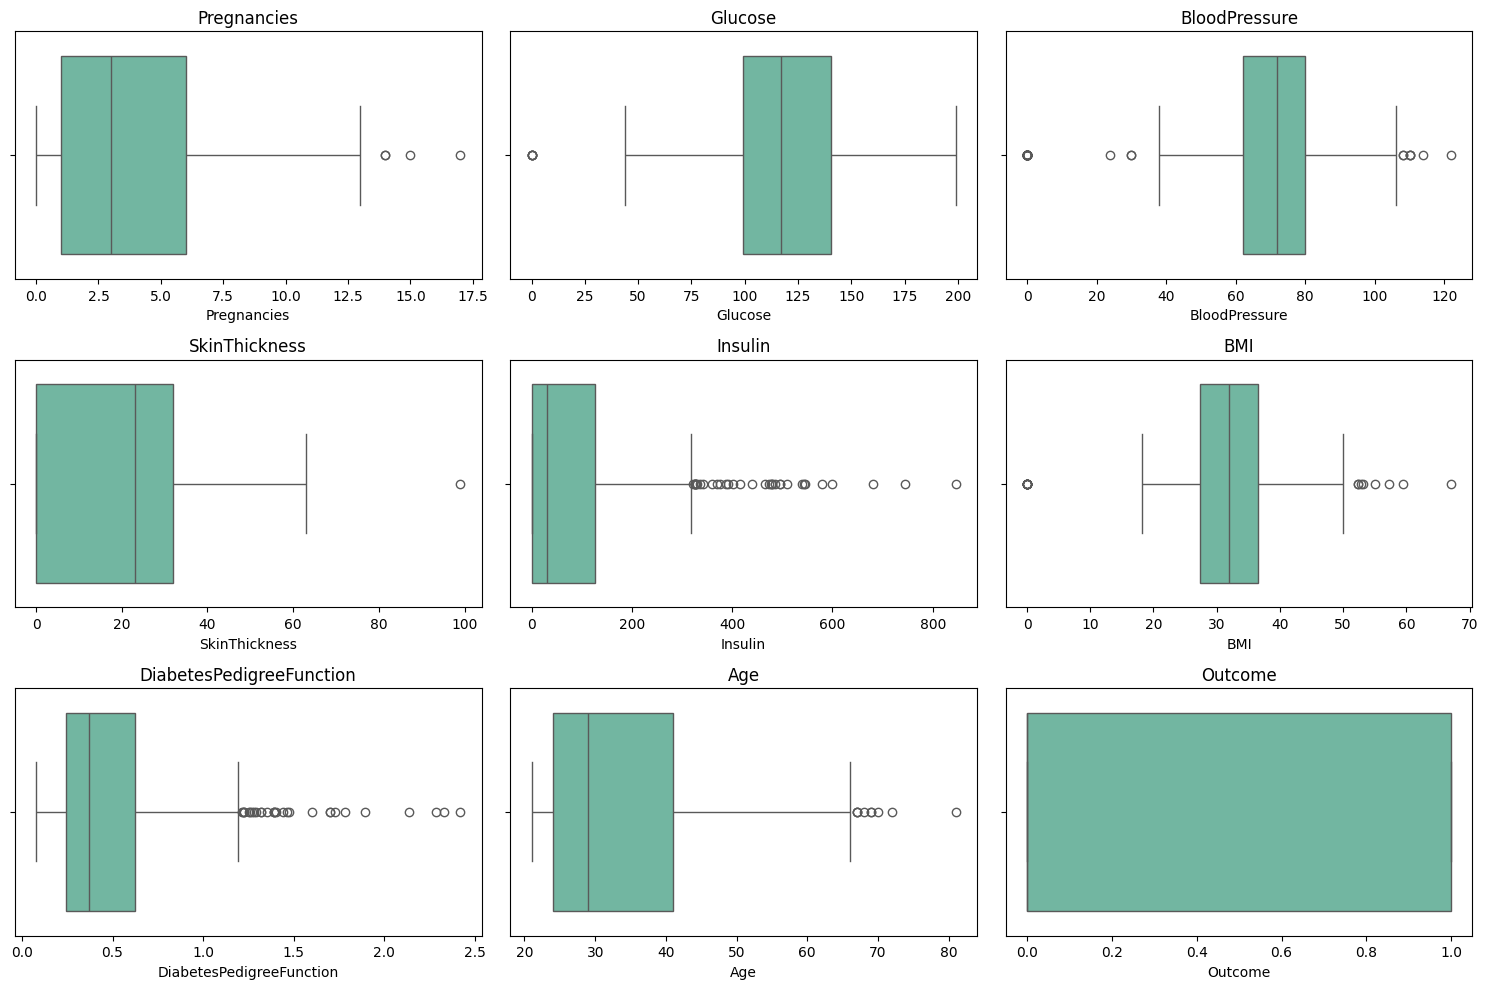

In [342]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()  # Dimension Reduction for 3x3 matrix structure

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i], orient="h", palette="Set2")
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Prevents plots from tightening
plt.show()

By looking at this figplot above, we can see that there are features that have a big and little amount of outliers distinctly. Here the method we will be applying is:
1. Logically grouping (binning*) for more outliers
2. Z-score standardization for less outliers

Let's get started!


### **Here are the features that;**

-> have more outliers:
1. Insulin
2. Blood Pressure
3. BMI
4. Diabetes Pedigree Function

-> have less outliers:
1. Pregnancies
2. Glucose
3. Skin Thickness
4. Age

*Binning (also called bucketing) is a feature engineering technique that groups different numerical subranges into bins or buckets.

### Starting by Binning the First Group: More Outliers

In [343]:
more_outliers = ["Insulin", "BloodPressure", "BMI", "DiabetesPedigreeFunction"]
for col in more_outliers:
  print("{} is in the range of:\t{}-{}.\n".format(col, df[col].min(), df[col].max()))

Insulin is in the range of:	0-846.

BloodPressure is in the range of:	0-122.

BMI is in the range of:	0.0-67.1.

DiabetesPedigreeFunction is in the range of:	0.078-2.42.



Let's apply the following:

✔ Insulin → Divided into 5 categories    ✅ → "Equal-width binning"

✔ BloodPressure → Divided into quartiles ✅ → "Equal-frequency binning (quantile binning)"

✔ BMI → Classified based on health standards ✅ → "Medical classification"

✔ DiabetesPedigreeFunction → Grouped into Low, Medium, and High risk ✅ → "Risk-based categorization"

* We will be using pd.cut, which is used to cut the numerical data into dedicated intervals and generally to generate binned (grouped) data.

- We will apply them into a copy of the dataset, so we will be also saving the original df to compare.

In [344]:
df_copy = df.copy()

In [345]:
df_copy["Insulin_Bin"] = pd.cut(df["Insulin"], bins=5, labels=[0, 1, 2, 3, 4]) # 0: "Very Low", 1: "Low", 2: "Medium", 3: "High", 4: "Very High""

df_copy["BMI_Bin"] = pd.cut(df["BMI"], bins=[0.0, 18.5, 25, 30, 35, 67.1], labels=[0, 1, 2, 3, 4], right=True) # 0: "Underweight", 1: "Normal", 2: "Overweight", 3: "Obese", 4: "Morbidly Obese"

df_copy["DiabetesPedigreeFunction_Bin"] = pd.cut(df["DiabetesPedigreeFunction"], bins=[0, 0.3, 1.0, 2.5], labels=[0, 1, 2]) # 0: "Low Risk", 1: "Medium Risk", 2: "High Risk"

df_copy["BloodPressure_Bin"] = pd.qcut(df["BloodPressure"], q=4, labels=[0, 1, 2, 3]) # 0: "Low", 1: "Medium", 2: "High", 3: "Very High"

# We could have just applied label encoding after assigning string labels to the binned data groups, but we don't need our computer to do more tasks. So, we did it manually.
# But do not forget that we could've just converted them by using LabelEncoder from sklearn.preprocessing so easily, however, here we had much less columns so i didn't.

# Drop the columns to have a more structured version of the dataset
df_copy.drop(["Insulin", "BloodPressure", "BMI", "DiabetesPedigreeFunction"], axis=1, inplace=True)

In [346]:
print("Missing values of BMI_Bin column: ", df_copy["BMI_Bin"].isnull().sum())
# There happens to be some missing values, let's fill them up with median values since we categorized our column.

bmi_mode = df_copy["BMI_Bin"].mode()[0]
print("Mode value of binned BMI feature: ", bmi_mode)

Missing values of BMI_Bin column:  11
Mode value of binned BMI feature:  4


In [347]:
df_copy["BMI_Bin"].fillna(bmi_mode, inplace=True)
df_copy["BMI_Bin"] = df_copy["BMI_Bin"].astype(int)

In [348]:
df_copy[["Insulin_Bin", "DiabetesPedigreeFunction_Bin", "BloodPressure_Bin"]] = df_copy[["Insulin_Bin", "DiabetesPedigreeFunction_Bin", "BloodPressure_Bin"]].astype(int)

### _inplace_ parameter:
* When inplace=True is used, changes are applied directly to the existing DataFrame.
* When inplace=False (default), a copy with the changes is returned, leaving the original DataFrame unchanged.

## pandas.qcut function:
* pd.qcut() is used for **quantile-based** binning. It divides the data into equal-sized bins based on the distribution of values. This means that each bin contains approximately the same number of data points. This is useful when you want to group data in a way that ensures each bin has the same number of observations, regardless of the actual value range.

In [349]:
display(df_copy[["Insulin_Bin","BloodPressure_Bin", "BMI_Bin", "DiabetesPedigreeFunction_Bin"]].head())

,Insulin_Bin,BloodPressure_Bin,BMI_Bin,DiabetesPedigreeFunction_Bin
0,0,1,3,1
1,0,1,2,1
2,0,1,1,1
3,0,1,2,0
4,0,0,4,2


* **Important**: We will be applying scaling (normalization) to the all features ***AFTER*** splitting the train and test sets. But let's try both applied and non-applied versions' performance.

In [350]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Pregnancies                   768 non-null    int64
 1   Glucose                       768 non-null    int64
 2   SkinThickness                 768 non-null    int64
 3   Age                           768 non-null    int64
 4   Outcome                       768 non-null    int64
 5   Insulin_Bin                   768 non-null    int64
 6   BMI_Bin                       768 non-null    int64
 7   DiabetesPedigreeFunction_Bin  768 non-null    int64
 8   BloodPressure_Bin             768 non-null    int64
dtypes: int64(9)
memory usage: 54.1 KB


In [351]:
df_copy.head()

,Pregnancies,Glucose,SkinThickness,Age,Outcome,Insulin_Bin,BMI_Bin,DiabetesPedigreeFunction_Bin,BloodPressure_Bin
0,6,148,35,50,1,0,3,1,1
1,1,85,29,31,0,0,2,1,1
2,8,183,0,32,1,0,1,1,1
3,1,89,23,21,0,0,2,0,1
4,0,137,35,33,1,0,4,2,0


## Feature Scaling
In this section, we will be applying standardization or normalization to make features be compatible with each other. We will standardize df_copy now, and df_copy_not_scaled later.

In [352]:
df_copy_not_scaled = df_copy.copy()

In [353]:
# Apply Z-score normalization to the columns (excluding the target column 'Outcome')
df_copy[['Glucose', 'SkinThickness', 'Pregnancies', 'Age']] = scaler.fit_transform(df_copy[['Glucose', 'SkinThickness', 'Pregnancies', 'Age']])

# Check the first few rows after normalization
print(df_copy.head())

   Pregnancies   Glucose  SkinThickness  ...  BMI_Bin  DiabetesPedigreeFunction_Bin  BloodPressure_Bin
0     0.639947  0.848324       0.907270  ...        3                             1                  1
1    -0.844885 -1.123396       0.530902  ...        2                             1                  1
2     1.233880  1.943724      -1.288212  ...        1                             1                  1
3    -0.844885 -0.998208       0.154533  ...        2                             0                  1
4    -1.141852  0.504055       0.907270  ...        4                             2                  0

[5 rows x 9 columns]


In [354]:
df_copy.head()

,Pregnancies,Glucose,SkinThickness,Age,Outcome,Insulin_Bin,BMI_Bin,DiabetesPedigreeFunction_Bin,BloodPressure_Bin
0,0.639947,0.848324,0.907270,1.425995,1,0,3,1,1
1,-0.844885,-1.123396,0.530902,-0.190672,0,0,2,1,1
2,1.233880,1.943724,-1.288212,-0.105584,1,0,1,1,1
3,-0.844885,-0.998208,0.154533,-1.041549,0,0,2,0,1
4,-1.141852,0.504055,0.907270,-0.020496,1,0,4,2,0


## Feature Exploration with Visualization
Here we visualize how different features relate to the target variable, create plots (e.g., scatter plot or boxplot) to analyze the impact of glucose levels, age, or BMI on diabetes.

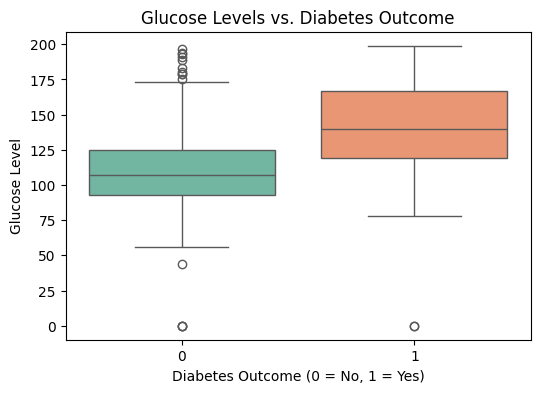

In [355]:
# Boxplot for Glucose vs. Outcome
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Outcome"], y=df["Glucose"], palette="Set2")
plt.title("Glucose Levels vs. Diabetes Outcome")
plt.xlabel("Diabetes Outcome (0 = No, 1 = Yes)")
plt.ylabel("Glucose Level")
plt.show()

From this comparisons of boxplots, we can make inferences regarding *the more glucose level, higher the risk of diabetes outcome*. However, there are a lot of outliers in diabetes == 0 too. Thus, we will make the final decision in the last (feature importance) part.

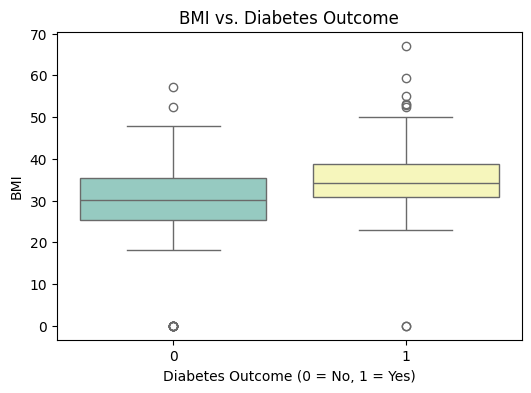

In [356]:
# Boxplot for BMI vs. Outcome
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Outcome"], y=df["BMI"], palette="Set3")
plt.title("BMI vs. Diabetes Outcome")
plt.xlabel("Diabetes Outcome (0 = No, 1 = Yes)")
plt.ylabel("BMI")
plt.show()

From the plot above, we can infer that the risk of diabetes dynamically increases along with the BMI level.

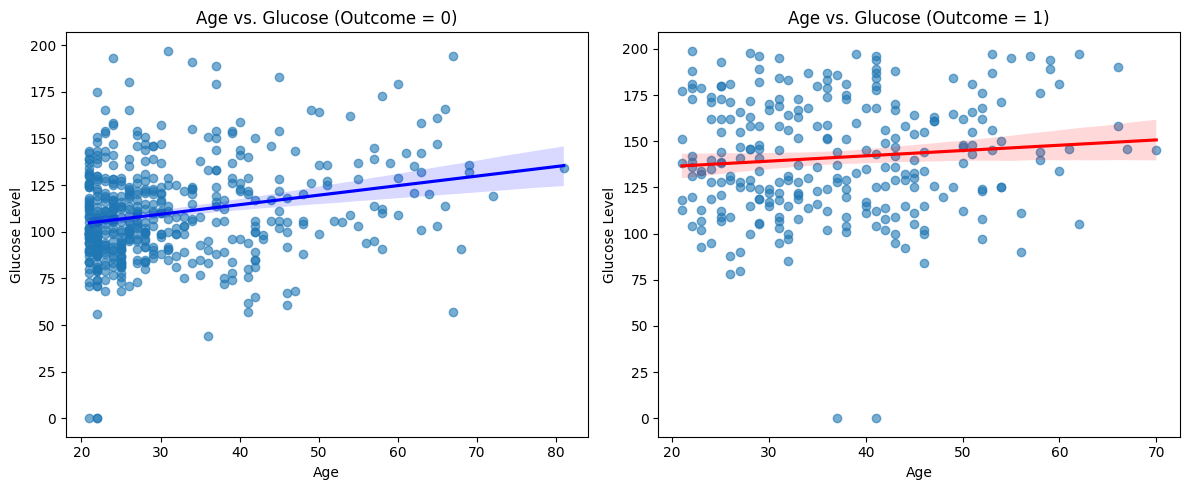

In [357]:
# Create a 1x2 subplot for linear regression lines for Outcome = 0 and Outcome = 1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Outcome = 0
sns.regplot(x=df[df["Outcome"] == 0]["Age"], y=df[df["Outcome"] == 0]["Glucose"], ax=axes[0], scatter_kws={'alpha':0.6}, line_kws={'color': 'blue'})
axes[0].set_title("Age vs. Glucose (Outcome = 0)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Glucose Level")

# Plot for Outcome = 1
sns.regplot(x=df[df["Outcome"] == 1]["Age"], y=df[df["Outcome"] == 1]["Glucose"], ax=axes[1], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
axes[1].set_title("Age vs. Glucose (Outcome = 1)")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Glucose Level")

plt.tight_layout()
plt.show()

From these plots above, we can infer that as the age increases the glucose level also tends to increase. However, since the diabetes outcome == 1 data in this dataset has shown a very uniform distribution as shown in the scatter plot above right. Therefore, it shows less correlation between age and glucose level in outcome = 1. YET we can clearly see that however the age is, glucose level is always higher in outcome 1's than outcome 0's, which leads us to realize glucose is related with diabetes a LOT.

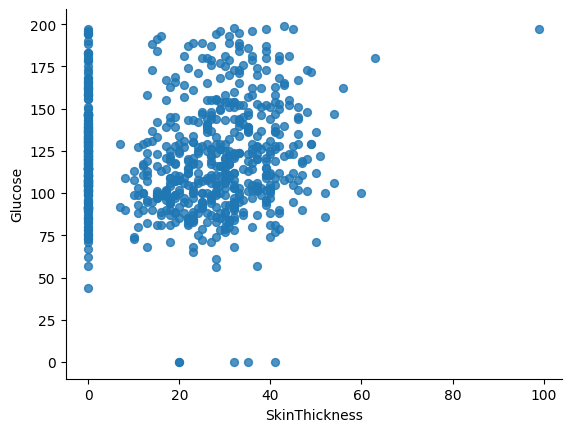

In [358]:
# @title SkinThickness vs Age

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='SkinThickness', y='Glucose', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

This plot shows us a uniform data but we can also clearly see that there are a lot of 0 values in SkinThickness column, which means missing data, outlier problem or it needs some business research. We will be further investigating it in the upcoming sections.

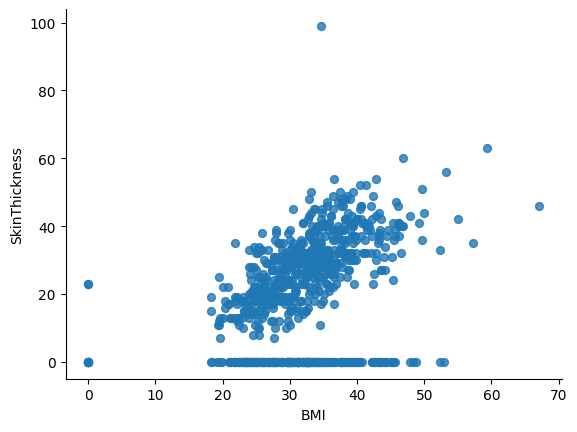

In [359]:
# @title Glucose vs SkinThickness

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='BMI', y='SkinThickness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

There is also a nonuniform distribution because of SkinThickness again. Let's handle those values.

## Feature Selection
Analyzing the relationships between independent variables and the target variable using a correlation matrix, removing unnecessary or highly correlated features to simplify the dataset.

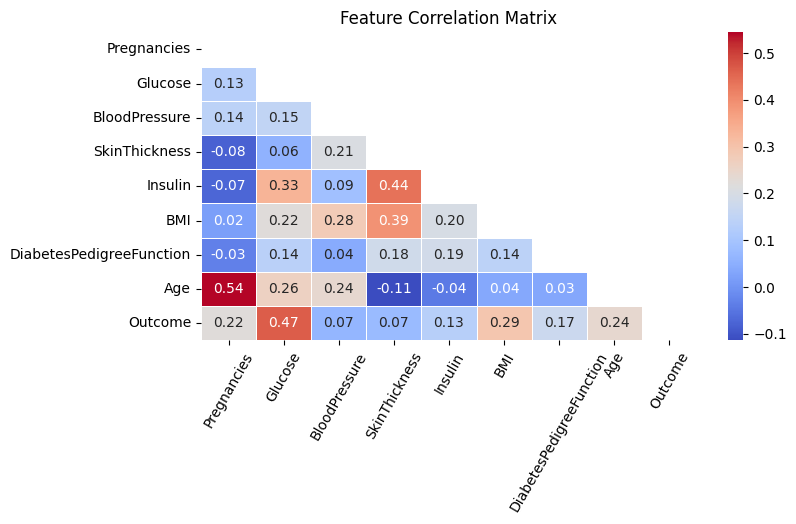

In [360]:
correlation_matrix = df.corr()

plt.figure(figsize=(8,4))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, mask=np.triu(correlation_matrix))

plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.title("Feature Correlation Matrix")
plt.show()

By looking at this heatmap, it's easy to say that there are not really intense correlation between any of two features in this dataset. So we won't be removing any features here. Let's check the standardized dataframe, *df_copy*.

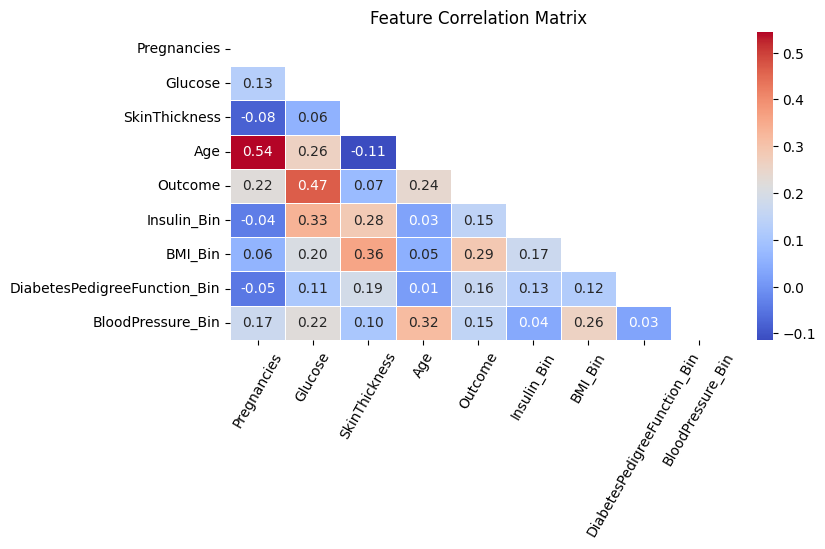

In [361]:
correlation_matrix = df_copy.corr()

plt.figure(figsize=(8,4))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, mask=np.triu(correlation_matrix))

plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.title("Feature Correlation Matrix")
plt.show()

* There isn't a vast change, but after standardization it became more obvious that there are observable changes between the correlation values. Even though it's quality is increased, still the highest correlation is 0.54 between "Age" and "Pregnancies".

## Creating a Prepared Dataset for Modelling & Performance Evaluations
We will finalize the processed dataset and test an initial classification model (e.g., Logistic Regression, Random Forest).
* As we mentioned before, here we will be using two different dataframes:
1. df_copy -> scaled before train test split
2. df_copy_not_scaled -> scaled after train test split

____

*Also*, we will be using two different methods to evaluate our performance:
1. **Logistic Regression:** A statistical model that predicts the probability of a binary outcome (e.g., diabetes or not) using a linear equation and the *sigmoid function*. It works well for linearly separable data.

2. **Random Forest:** An ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. It handles both linear and non-linear relationships effectively.

Let's see the performance difference between them!
### Using df_copy: Scaled before train test split

In [362]:
X = df_copy.drop(columns=["Outcome"])
y = df_copy["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [363]:
# Logistic Regression Prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Training
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.7208


Here our accuracy came out as 0.72, which is not a bad accuracy for initialization!

In [364]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.63      0.50      0.56        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



* The model shows decent performance with an accuracy of 72%. For class 0 (non-diabetic), it has good precision (76%) and recall (84%), while for class 1 (diabetic), precision is lower (63%) and recall is poorer (50%). The weighted average precision, recall, and F1-score are 71%, 72%, and 71%, respectively, suggesting the model performs better on class 0.

Now let us review the random forest learning.

In [365]:
# Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Random Forest Accuracy: 0.7078


Also here our accuracy came out as 0.7078, which is not a bad accuracy for initialization!

In [366]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       100
           1       0.59      0.54      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.70      0.71      0.70       154



* The model has an accuracy of 71%. For class 0 (non-diabetic), it performs well with a precision of 76% and recall of 80%. However, for class 1 (diabetic), both precision (59%) and recall (54%) are lower. The macro average precision, recall, and F1-score are around 67%, indicating a slight imbalance in the model's performance between the two classes. The weighted average values are slightly better, suggesting better performance on class 0.

### Using df_copy_not_scaled: Scaled after train test split

In [367]:
# Split the dataset into training and testing sets
X = df_copy_not_scaled.drop(columns=["Outcome"])
y = df_copy_not_scaled["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("The {} dataset is normalized.".format(str(df_copy_not_scaled)))

The      Pregnancies  Glucose  SkinThickness  ...  BMI_Bin  DiabetesPedigreeFunction_Bin  BloodPressure_Bin
0              6      148             35  ...        3                             1                  1
1              1       85             29  ...        2                             1                  1
2              8      183              0  ...        1                             1                  1
3              1       89             23  ...        2                             0                  1
4              0      137             35  ...        4                             2                  0
..           ...      ...            ...  ...      ...                           ...                ...
763           10      101             48  ...        3                             0                  2
764            2      122             27  ...        4                             1                  1
765            5      121             23  ...        2      

In [368]:
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.7208


Here our accuracy came out as 0.72, which is not a bad accuracy for initialization!

In [369]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.63      0.50      0.56        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



* The model has an accuracy of 72%. For class 0 (non-diabetic), the performance is relatively good with a precision of 76% and recall of 84%. However, for class 1 (diabetic), precision drops to 63% and recall to 50%, indicating that the model struggles to identify diabetic cases. The macro average precision, recall, and F1-score are lower (around 68%), showing that the model's performance is not equally strong for both classes. The weighted averages are slightly better, with overall performance closer to the class distribution.

In [370]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Random Forest Accuracy: 0.7078


Here our accuracy came out as 0.7078, which is not a bad accuracy for initialization!

Additionally, we've seen that scaling before or after train-test split didn't make much (even a little) change here. However there will be cases which it will make differences.

In [371]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       100
           1       0.59      0.54      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.70      0.71      0.70       154



* The model has a 71% accuracy. It performs better for class 0 (precision: 76%, recall: 80%) but struggles with class 1 (precision: 59%, recall: 54%). The overall performance is unbalanced, with macro and weighted averages around 67-70%.

## Results and Inferences
The results show that the models performed reasonably well, with an accuracy of around 71-72%. However, the recall for the diabetic class (label 1) was lower, indicating that the model might be missing some positive cases. The precision for non-diabetic cases was higher, meaning the model was better at correctly identifying people without diabetes. This suggests that while the model has potential, there is still room for improvement in detecting diabetic cases more accurately. Further tuning or data balancing could help address these issues.